<a href="https://colab.research.google.com/github/dkaratzas/ML2024-25/blob/main/Session%2010%20-%20EM/P10_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/ML2024-25/blob/main/Session%2010%20-%20EM/P10_EM.ipynb>)

# Problems 10 - Expectation Maximisation

In this notebook we will define our own version of a Gaussian Mixture Model and use it to represent distributions and to create new samples out of them.

Then we will implement our own version of the Expectation Maximisation algorithm, and compare it with the sklearn implementation. We will take advantage of all the action to explore a couple of ways to visualise data in 3D.

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# 10.1 - Gaussian Mixture Model

A Gaussian Mixture Model is basically a weighted sum of Normal (Gaussian) distributions:

$$𝑝(𝐱)=\sum_{k=1}^{N}\pi_kN(x\mid\mu_k,\Sigma_k)$$

where $\sum_{k=1}^{N}\pi_k=1$.

To manage this, we will create a class that will basically act as a collection of Normal distributions. We will provide the class means $\mu_k$ and covariances $\Sigma_k$, as well as the mixing coefficients $\pi_k$. Below is the code for this class. Go over it and try to understand what each function is supposed to do.

In [67]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, means, covs, coefs):
        """Class initilization.

        Keyword arguments:
        means -- a list of mean vectors, one for each component
        covs  -- a list of covariance matrices, one for each component
        coefs -- a list of mixing coefficients
        
        The function checks that the number of means, covariance matrices 
        and mixing coefficients agree. Otherwise it raises an exception.
        It normalises the coeficient values (so they do not have to sum to
        1 when specified), but they have to be all positive numbers.
        """        
        assert (means.ndim == 2)
        self.nComponents, self.dim = means.shape

        assert (coefs.ndim == 1)
        assert (means.shape[0] == coefs.shape[0] == self.nComponents)
        assert (covs.shape[1] == covs.shape[2] == self.dim)
        assert all(coefs > 0)
        self.means = means
        self.covs = covs
        self.coefs = coefs / coefs.sum() # Make sure these are valid probabilities
                           
    def __str__(self):
        """String representation of the class.        
        Returns an informative string about our class.
        """
        return f"GMM with {self.nComponents} components"
        
    def __call__(self, x):
        """Implements the call operator. This enables instances of our class to
        behave like functions and be called like a function.        
        It returns the probability density value at x. For this it calls the pdf() 
        function that is an alternative way to do that.
        """
        return self.pdf(x)
        
    def pdf(self, x):
        """Returns the probability density value at x.
        """
        out = 0        
        for mean, cov, coef in zip(self.means, self.covs, self.coefs):
            out += coef * multivariate_normal(mean, cov).pdf(x)
        return out
    
    def sample(self, size = None):        
        """Returns a set of feature vector, according to the size specified, sampled from the GMM.
        The final result will be of size (size, dim), where dim is the dimensionality of the feature vector
        """
        # Select random components, as many as "size" indicates
        c = np.random.choice(np.arange(self.nComponents), size=size, replace=True, p=self.coefs) #select one 
        
        # c will have the size the user specified, make it a list of indices
        clist = c.reshape(-1, 1).squeeze()
        
        # Check in case we only got a single number (not an array)
        if clist.ndim == 0: # this would happen if the user asked for only one element (dimensionality = 0), then expand it so that the rest works
            clist = np.expand_dims(clist, 0)
        
        # create the output array, as an array of size like the list of indices
        out = np.zeros( (clist.shape[0], self.dim) )
        
        # Generate samples from the corresponding clusters
        for i, cl in enumerate(clist):
            out[i] = np.random.multivariate_normal(self.means[cl], self.covs[cl])
            
        # Reshape out back to the desired size        
        out = out.reshape(c.shape + (self.dim,))
        #out = out.reshape(np.hstack( (c.shape, self.dim)).astype(int) )  # Alternative way to do this
        
        return out

Let´s first have a look at the `GMM.pdf()` fuction of this class. This class returns the probability of our GMM at some input point $x$. To understand how it works, check the documentation of the function `scipy.stats.multivariate_normal()` here:
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html

To test our function, we will manually define a GMM with two components, then use the `GMM.pdf()` function to calculate the probability density at some point $x$. We will work in a 2D space.

In [68]:
from sklearn.datasets import make_spd_matrix

rng = 12 # range to use for sampling (go by -12 to 12)

nComponents = 2
means = np.random.uniform(-rng+2, rng-2, size = (nComponents, 2)) #create vectors ncomponents
covs = np.array( [make_spd_matrix(n_dim=2, random_state=r) for r in np.random.randint(100, size = nComponents)] ) #2by2 matrices
coefs = np.random.uniform(1, 5, nComponents)
coefs /= nComponents # mixing coefficients, normalised

In [69]:
gmm = GMM(means, covs, coefs)
x = np.array([0, 0]) #point at 0,0
print(gmm.pdf(x)) #calls the pdf function to use it later like a function
print(gmm(x))

print(gmm(means))

0.00025875609514917854
0.00025875609514917854
[0.07004279 0.08766797]


Now have a look at the `GMM.sample()` function of our class. This function generates samples from our GMM distribution. To understand how it works, check the documentation of the function `random.multivariate_normal()` here:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html

And the function `numpy.random.choice()` here:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

Here are some tests of our sampling method:

In [70]:
# Test 1 - generate a single sample
gmm.sample(1)

array([[7.22450194, 7.37578393]])

In [71]:
# Test 2 - generate a set of 5 samples
gmm.sample(5)

array([[0.10609119, 7.62149502],
       [3.08183739, 7.03715611],
       [4.44060517, 8.25004094],
       [7.28497931, 7.69392981],
       [3.62395723, 7.45163803]])

In [72]:
# Test 3 - generate a set of 5 samples (alternative way)
gmm.sample([5])

array([[ 0.56155828, -1.05542876],
       [ 0.30794029,  6.79771679],
       [ 1.79849122,  8.08592863],
       [ 4.3079038 ,  8.51737559],
       [-1.87344203, -0.89322599]])

In [73]:
# Test 3 - generate an array of samples of the size given
gmm.sample([2, 3])

array([[[ 0.0307309 , -1.24365163],
        [-1.80942032, -2.34663616],
        [ 4.10217322,  7.61587892]],

       [[ 1.3340724 ,  7.08925826],
        [-0.31574066, -1.60394789],
        [ 2.43572706,  8.30940022]]])

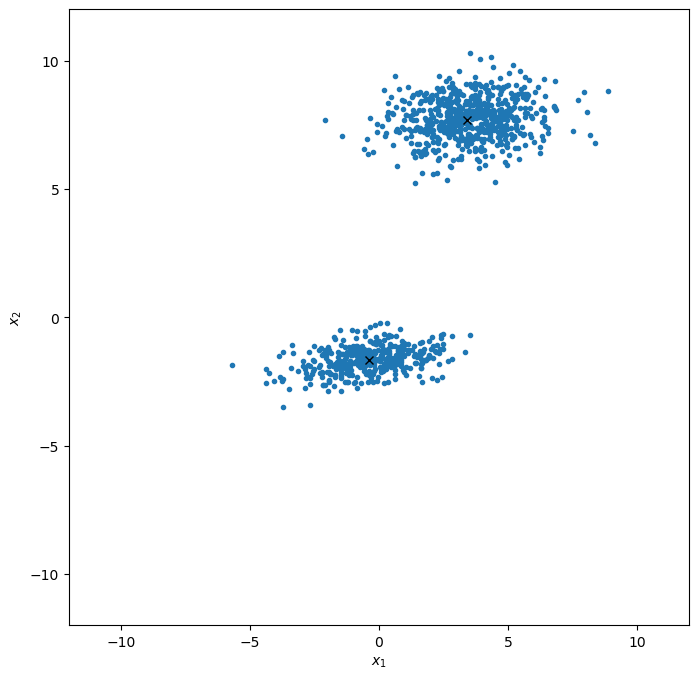

In [74]:
# Do some plotting
fig = plt.figure(figsize = (8, 8))

data = gmm.sample(1000) # generate 1000 samples
plt.scatter(data[:,0], data[:,1], marker = ".")
plt.plot(means[:,0], means[:,1], "kx")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-rng, rng)
plt.ylim(-rng, rng)
plt.show()

Each one probably got a different result, as we randomly generated means, covariances and samples. We will now formalise our initialisation procedure, to create random means, covariances, and mixing coefficients in the same way, by controlling the seed we use

In [75]:
# Initialization
from sklearn.datasets import make_spd_matrix

def initialise(nComponents, rng = 10, random_seed = 6):

    np.random.seed(random_seed)

    coefs = np.ones(nComponents)/nComponents # mixing coefficients

    means = np.random.uniform(-rng+2, rng-2, size = (nComponents, 2))
    covs = np.array( [make_spd_matrix(n_dim=2, random_state=r) for r in np.random.randint(100, size = nComponents)] )
    
    return means, covs, coefs

In [76]:
nComponents = 2
means, covs, coefs = initialise(nComponents)

In [77]:
gmm = GMM(means, covs, coefs)
print(gmm)

GMM with 2 components


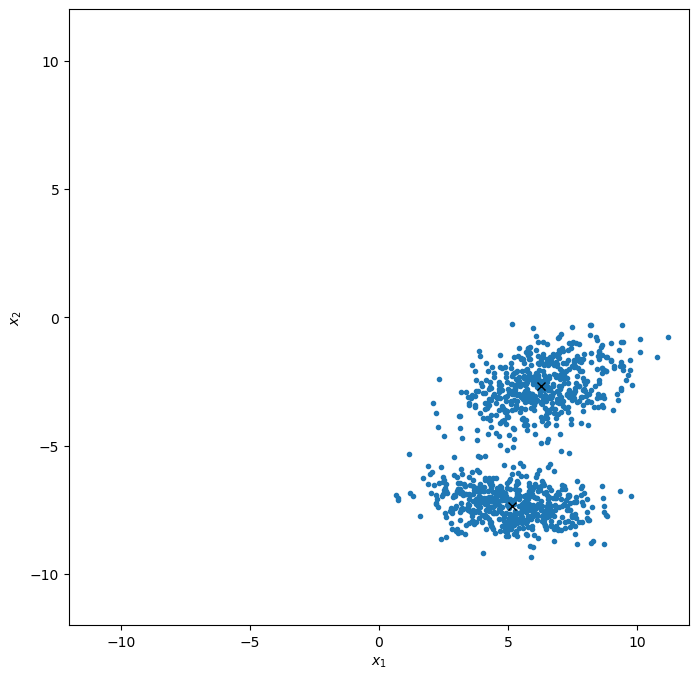

In [78]:
# Do some plotting
fig = plt.figure(figsize = (8, 8))

data = gmm.sample(1000)
plt.scatter(data[:,0], data[:,1], marker = ".")
plt.plot(means[:,0], means[:,1], "kx")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-rng, rng)
plt.ylim(-rng, rng)
plt.show()

In [79]:
gmm( [0, 0] ) # The probability density function at [0, 0]

1.5471807357298683e-09

## 10.2 - Expectation Maximisation

Here we will use our our implementation of Expectation Maximisation.

We will initialise with some random clusters, and apply EM on the data they have provided us. First we will load and explore the data we have been given.

In [80]:
import pickle
import gzip

In [81]:
with gzip.open('data.pklz', 'rb') as f:
    (X, y) = pickle.load(f)

Let's first explore a bit and visualise the data we just loaded

In [82]:
print("Feature dimension: ", X.ndim)
for i, column in enumerate(X.T):
    print("Feature {index} in [{minimum:.2f}, {maximum:.2f}]".format(index = i, minimum = column.min(), maximum = column.max()))
    
for label in np.unique(y):
    print("Label {} count: {} ({:.2f}%)".format(label, np.sum(y == label), 100*np.sum(y == label)/len(y) ))

Feature dimension:  2
Feature 0 in [-8.36, 11.69]
Feature 1 in [-10.37, 6.14]
Label 0 count: 63 (31.50%)
Label 1 count: 137 (68.50%)


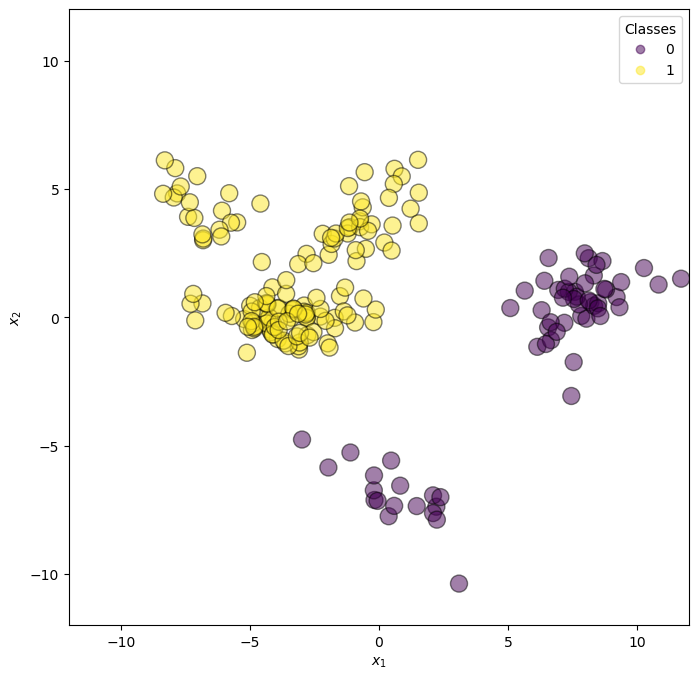

In [83]:
fig = plt.figure(figsize = (8, 8))
scatter = plt.scatter(X[:,0], X[:,1], c = y, marker = "o", alpha = 0.5, cmap="viridis", label = y, s=150, edgecolors="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-rng, rng)
plt.ylim(-rng, rng)
plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
plt.show()

Now for the implementation of our Expectation Maximisation function. We will start with a number of random components. Then in every iteration (epoch) we will calculate:

**EXPECTATION STEP:**

(1) the "responsibilities" of each component for each point of our dataset:

$$\gamma(z_{nk})=\frac{\pi_k N(x^{(n)}\mid\mu_k, \Sigma_k)}{\sum_{j=1}^K\pi_j N(x^{(n)}\mid\mu_j, \Sigma_j)} $$

**MAXIMISATION STEP:**

(2) the new means:

$$\mu_k^{new}=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})x^{(n)}$$

(3) the new covariance matrices:

$$\Sigma_k^{new}=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(x^{(n)}-\mu_k^{new})(x^{(n)}-\mu_k^{new})^T$$

where

$$N_k=\sum_{n+1}^N\gamma(z_{nk})$$

In [84]:
from scipy.stats import multivariate_normal
#efficient type
def em(X, means, covs, coefs, nIter = 100, resetSingulars = False, epsilon = 1e-6):
    '''Implements the Expectation - Maximisation algorithm for estimating probability density using a Gaussian Mixture Model
    means          - The initial means to use
    covs           - The initial covariance matrices to use
    coefs          - The initial mixture coefficients to use
    nIter          - Number of epochs to do
    resetSingulars - If True, it checks for singular compoments and resets them to a new position. If False, 
                     it avoids singular components by adding a small epsilon value on the diagonal of all covariance matrices
    epsilon        - The epsilon to use if resetSingulars is set to False
    '''
    for epochs in range(nIter):
        # (E-Step)
        # Calculate the responsibilities
        gamma = np.array([z * multivariate_normal(m, c).pdf(X) for m, c, z in zip(means, covs, coefs)]) #every point the responsability, for every component of the list and make an array
        gamma /= gamma.sum(axis=0)

        # (M-Step)
        # Calculate the Ns (the sum of this vector should equal the total number of points)
        N = gamma.sum(axis = 1)

        # Calculate means
        means = np.array([(gamma[i,:] * X.T).sum(axis=1)/n for i, n in enumerate(N)])

        # Calculate new coefficients
        coefs = N/sum(N)

        # Calculate covariances
        covs = np.array([(gamma[i,:] * (X - m).T) @ (X - m)/n for i, (m, n), in enumerate(zip(means, N))])    

        # Deal with any singular components, we offer two ways
        if resetSingulars:
            # Check if any component has become singular and reset it to a random place
            nDims = means.shape[1]
            if any(np.linalg.matrix_rank(covs) < nDims): #singular matrix
                print("Singular covariance found, resetting component")
                idx = (np.linalg.matrix_rank(covs) < nDims)
                nSingulars = idx.sum()
                means[idx] = np.random.uniform(-rng+2, rng-2, size = (nSingulars, 2))
                covs[idx] = np.array( [make_spd_matrix(n_dim=nDims, random_state=r) for r in np.random.randint(100, size = nSingulars)] )
                coefs[idx] = (1/coefs.shape[0])
                coefs = coefs/sum(coefs)
        else:
            # Or alternatively, do not reset any component, just avoid singularities
            covs += epsilon * np.identity(covs.shape[1]) # Avoid singular matrices
            
    return means, covs, coefs

Set some initial values for the components, and run the EM algorithm on our dataset

In [85]:
nComponents = 2
means, covs, coefs = initialise(nComponents)

In [86]:
pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs)

<font color = "blue">Create a GMM using the predicted means, covariance matrices, and mixing coeficients and generate 500 samples. Then plot the generated points - do they make sense? </font>

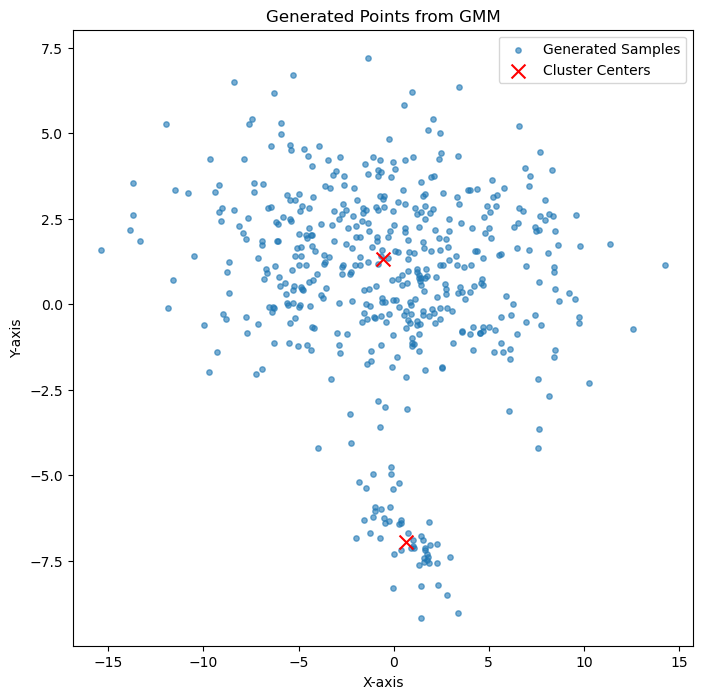

In [87]:
# YOUR CODE HERE
gmm = GMM(pred_means, pred_covs, pred_coefs)

# Generate 500 samples
samples = gmm.sample(size=500)

# Plot the generated samples
plt.figure(figsize=(8, 8))
plt.scatter(samples[:, 0], samples[:, 1], s=15, alpha=0.6, label='Generated Samples')
plt.scatter(pred_means[:, 0], pred_means[:, 1], color='red', marker='x', s=100, label='Cluster Centers')
plt.title("Generated Points from GMM")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.show()

---

*YOUR ANSWER HERE*

The generated points form two clear groups around the predicted centers, as expected from the Gaussian Mixture Model. The red markers show the predicted centers of the groups, and the spread of the points matches the shape and size of each group. This shows that the GMM is working correctly.

---

Here's a function to plot contours

In [88]:
def plot_contours(f, data, means = None, labels = None, xlim = (-12, 12), ylim = (-12, 12), resolution = 100):
    '''Plots contours, given a function f
    f          - reference to a function that accepts 2-dimensional points as input. E.g. f([x, y])
    data       - a list of data points. Rows are points, columns are features. 2-dimensional points are expected (extra dimensions are ignored)
    labels     - if given, they will be used to colour the points
    xlim       - the x-limits of the plot
    ylim       - the y-limits of the plot
    resolution - the sampling resolution to use to calculate the contours
    '''
    XX = np.linspace(xlim[0], xlim[1], resolution)
    YY = np.linspace(ylim[0], ylim[1], resolution)

    XX, YY = np.meshgrid(XX, YY)

    ZZ = f( np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1)) ) )
    ZZ = ZZ.reshape(XX.shape)
    
    fig = plt.figure(figsize = (5, 5), dpi = 150)

    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

    cm = plt.cm.Set1
    plt.scatter(data[:,0], data[:,1], color = "grey" if (labels is None) else cm(labels), marker = ".")

    cm = plt.cm.coolwarm
    levels = np.linspace(0.0001, min(0.04, np.max(ZZ)), 7)
    plt.contour(XX, YY, ZZ, cmap = cm, levels = levels)
    
    if means is not None:
        plt.plot(means[:, 0], means[:, 1], "kx")

    plt.show()

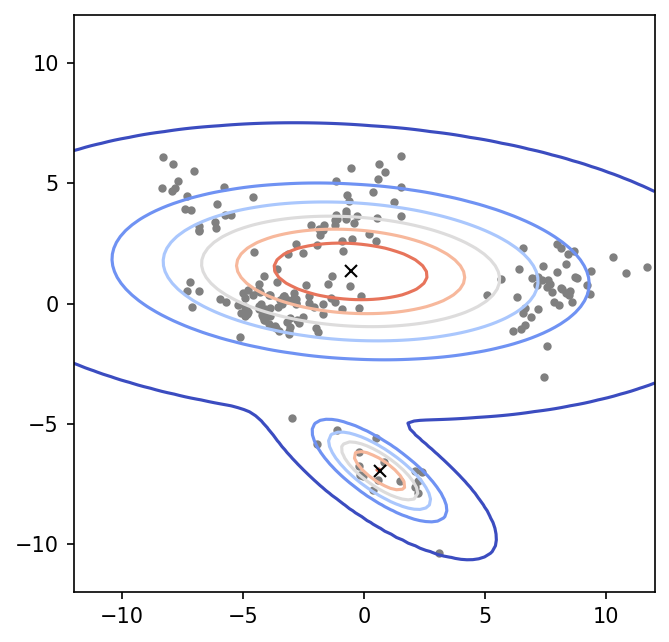

In [89]:
plot_contours(gmm, X, pred_means)

Just to do a quick check, we calculate the volume under surface in the region plotted (should be close to 1, as most of the action happens here, but the GMM extends to infinity, so there is a part of the volume outside the shown region)

In [90]:
import numpy as np
import scipy.spatial

def trapezoidal_area(xyz):
    """Calculate volume under a surface defined by irregularly spaced points
    using delaunay triangulation. "x,y,z" is a <numpoints x 3> shaped ndarray."""
    d = scipy.spatial.Delaunay(xyz[:,:2])
    tri = xyz[d.simplices]

    a = tri[:,0,:2] - tri[:,1,:2]
    b = tri[:,0,:2] - tri[:,2,:2]
    vol = np.cross(a, b) @ tri[:,:,2]
    return vol.sum() / 6.0

In [91]:
XX = np.linspace(-12, 12, 100)
YY = np.linspace(-12, 12, 100)
XX, YY = np.meshgrid(XX, YY)
ZZ = gmm( np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1)) ) )

xyz = np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1), ZZ.reshape(-1, 1)))

trapezoidal_area(xyz)

0.9788906932120945

Here are a couple of more plots, to help with your exploration.

In [92]:
def plot_surface(f, data, labels = None, xlim = (-12, 12), ylim = (-12, 12), resolution = 100):
    '''Plots a surface plot, given a function f
    f          - reference to a function that accepts 2-dimensional points as input. E.g. f([x, y])
    data       - a list of data points. Rows are points, columns are features. 2-dimensional points are expected (extra dimensions are ignored)
    labels     - if given, they will be used to colour the points
    xlim       - the x-limits of the plot
    ylim       - the y-limits of the plot
    resolution - the sampling resolution to use to calculate the contours
    '''
    XX = np.linspace(xlim[0], xlim[1], resolution)
    YY = np.linspace(ylim[0], ylim[1], resolution)

    XX, YY = np.meshgrid(XX, YY)

    ZZ = f( np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1)) ) )
    ZZ = ZZ.reshape(XX.shape)
    
    fig = plt.figure(figsize = (5, 5), dpi = 150)
    ax = fig.add_subplot(projection = "3d")

    zl = 0.04 # The z limit we will use

    # Plot the 3D surface    
    ax.plot_surface(XX, YY, ZZ, edgecolor='royalblue', lw=0.2, rstride=2, cstride=2, alpha=0.3,  cmap = 'coolwarm')
    
    # Set axis limits, labels, ticks
    ax.set(xlim=xlim, ylim=ylim, zlim=(0, zl), xlabel='$x_1$', ylabel='$x_2$', zlabel='$p(x)$')
    ax.set_xticks(np.arange(xlim[0], xlim[1]+1, 5) )
    ax.set_yticks(np.arange(xlim[0], xlim[1]+1, 5) )

    # Rotate the graph    
    ax.view_init(elev = 25, azim = -70)

    plt.show()

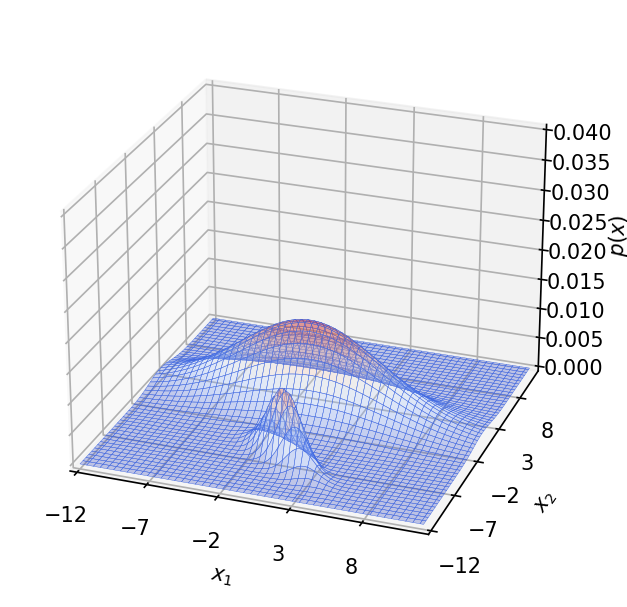

In [93]:
plot_surface(gmm, X)

In [94]:
def plot_combined(f, data, labels = None, xlim = (-12, 12), ylim = (-12, 12), resolution = 100):
    '''Plots a combined contour and surface plot, given a function f
    f          - reference to a function that accepts 2-dimensional points as input. E.g. f([x, y])
    data       - a list of data points. Rows are points, columns are features. 2-dimensional points are expected (extra dimensions are ignored)
    labels     - if given, they will be used to colour the points
    xlim       - the x-limits of the plot
    ylim       - the y-limits of the plot
    resolution - the sampling resolution to use to calculate the contours
    '''
    XX = np.linspace(xlim[0], xlim[1], resolution)
    YY = np.linspace(ylim[0], ylim[1], resolution)

    XX, YY = np.meshgrid(XX, YY)

    ZZ = f( np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1)) ) )
    ZZ = ZZ.reshape(XX.shape)
    
    fig = plt.figure(figsize = (5, 5), dpi = 150)
    ax = fig.add_subplot(projection = "3d")

    zl = 0.04 # The z limit we will use

    # Plot the 3D surface
    ax.plot_surface(XX, YY, ZZ, edgecolor='royalblue', lw=0.2, rstride=1, cstride=1, alpha=0.3,  cmap = 'coolwarm')

    # Plot a projection of the contour
    ax.contourf(XX, YY, ZZ, zdir='z', offset=-2*zl, cmap='coolwarm')

    # Plot the data
    ax.scatter(X[:,0], X[:,1], -2*zl, c = "black", marker = "+", s= 10, linewidth = 0.5)

    # Rotate the graph
    ax.view_init(elev = 20, azim = -60)

    # Set axis limits, labels, ticks
    ax.set(xlim=(-rng, rng), ylim=(-rng, rng), zlim=(-2*zl, zl), xlabel='$x_1$', ylabel='$x_2$', zlabel='$p(x)$')
    ax.set_xticks(np.arange(-rng, rng+1, 5) )
    ax.set_yticks(np.arange(-rng, rng+1, 5) )

    plt.show()

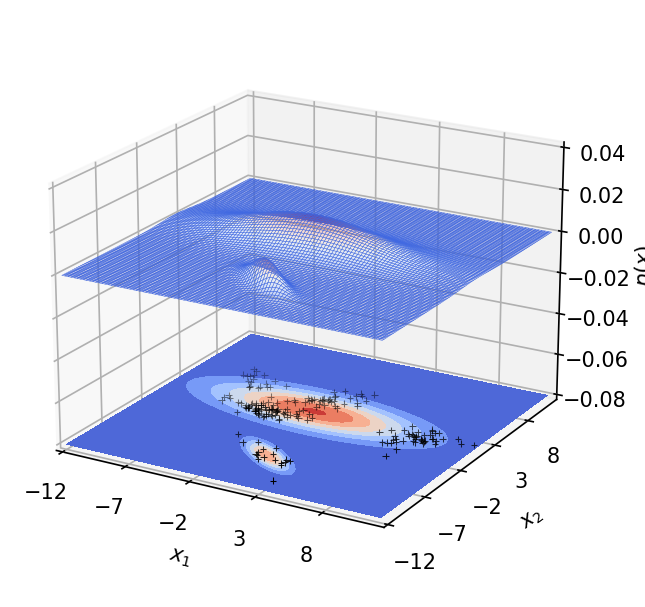

In [95]:
plot_combined(gmm, X)

<font color ="blue">Now, try fitting an GMM model using EM with a different number of components, or try to randomise the initialisation differently, try to use both ways provided to deal with singular components, etc. Report your findings.</font>


--- Results for 1 Components ---


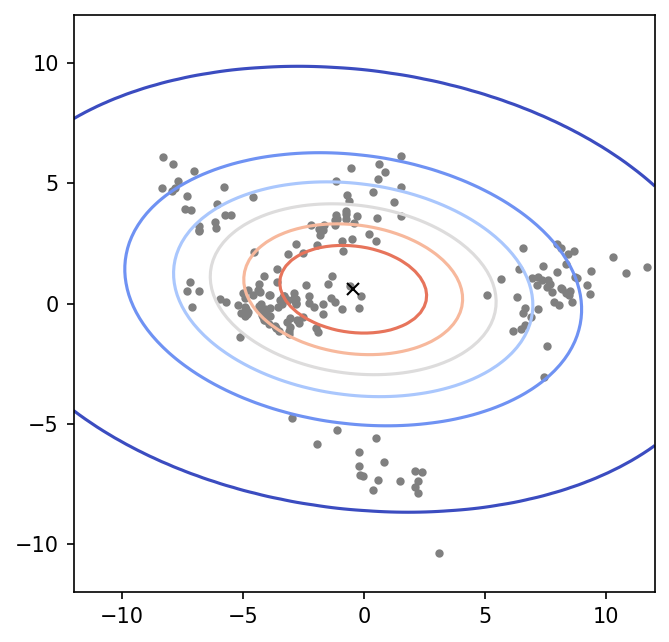

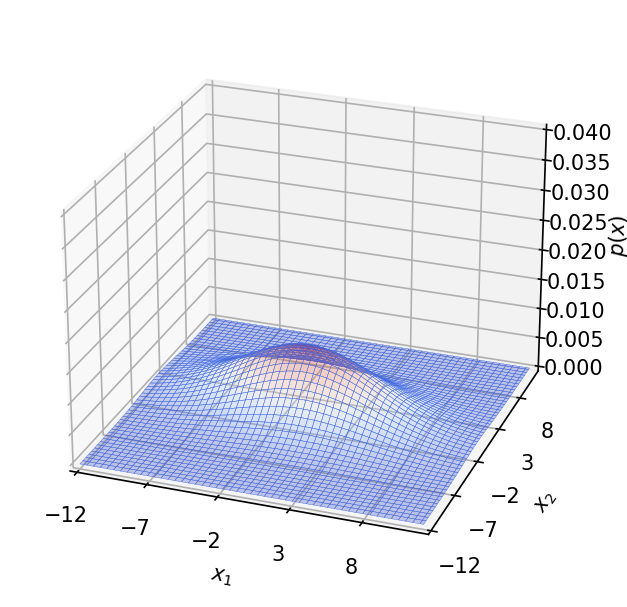


--- Results for 2 Components ---


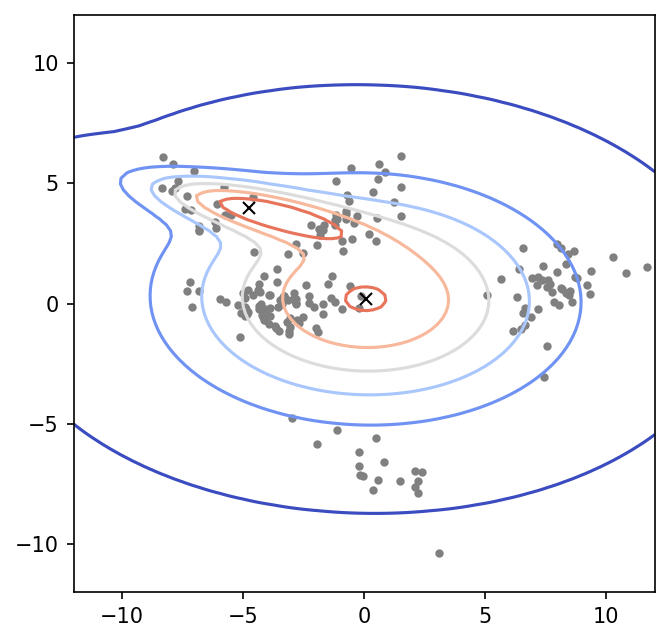

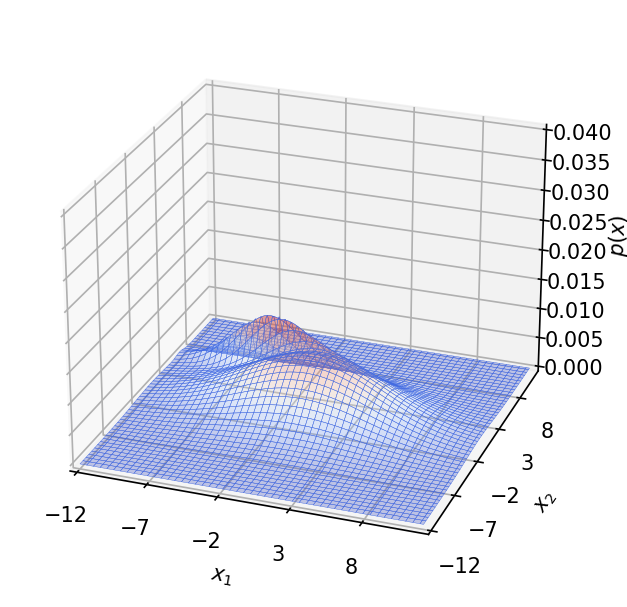


--- Results for 3 Components ---


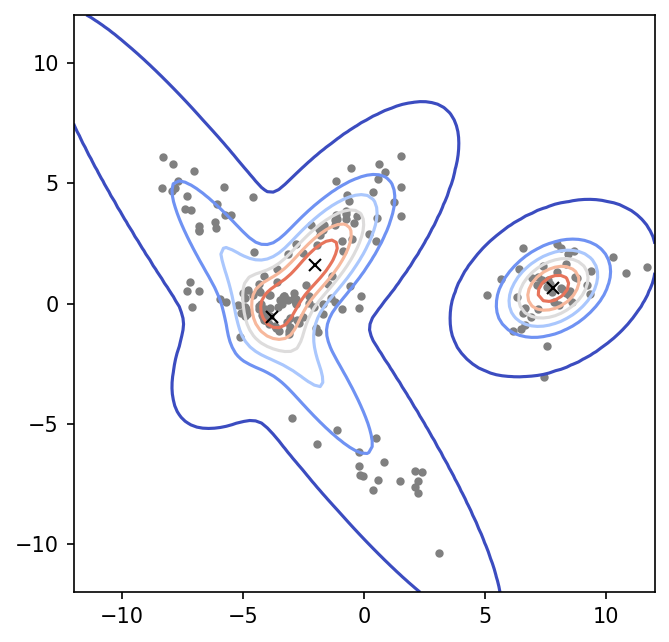

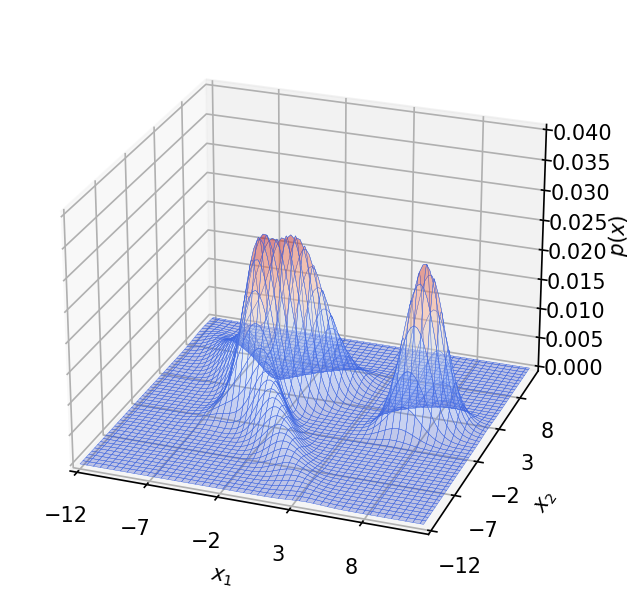


--- Results for 4 Components ---


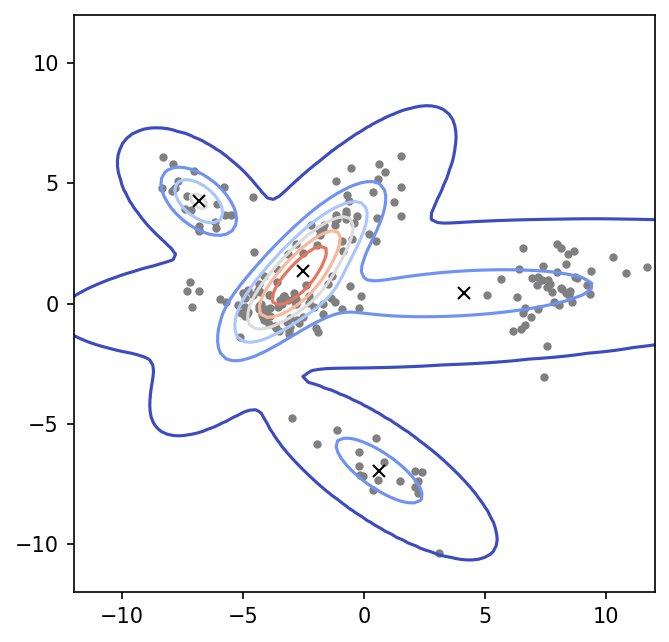

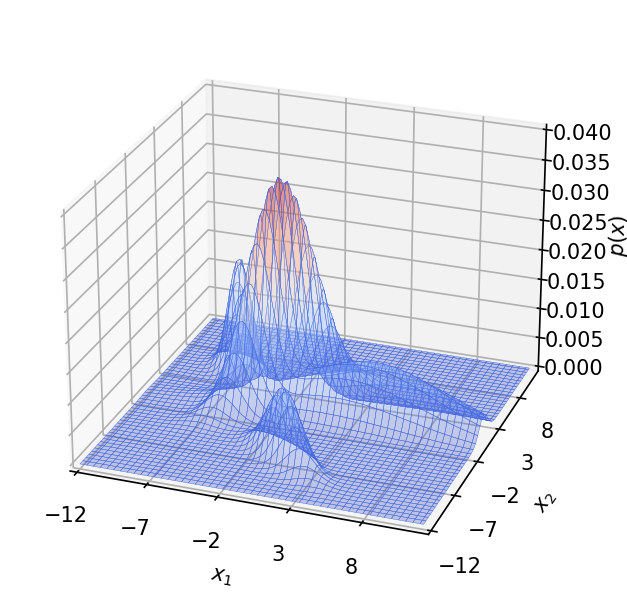

In [96]:
# YOUR CODE HERE
#center, more iterations, prove new things
# Experiment 1: Fit GMMs with different numbers of components
results = []
for n_components in [1, 2, 3, 4]:
    # Initialize parameters
    means, covs, coefs = initialise(n_components, rng=10, random_seed=42)
    
    # Run EM algorithm
    pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs)
    
    # Save results
    results.append({
        "n_components": n_components,
        "means": pred_means,
        "covs": pred_covs,
        "coefs": pred_coefs
    })

    # Define GMM from parameters
    gmm = GMM(pred_means, pred_covs, pred_coefs)
    
    # Define function to evaluate probability density for plotting
    def pdf_func(points):
        return np.array([gmm.pdf(p) for p in points])

    # Plot the results (contour and surface plots)
    print(f"\n--- Results for {n_components} Components ---")
    plot_contours(pdf_func, X, means=pred_means)
    plot_surface(pdf_func, X)



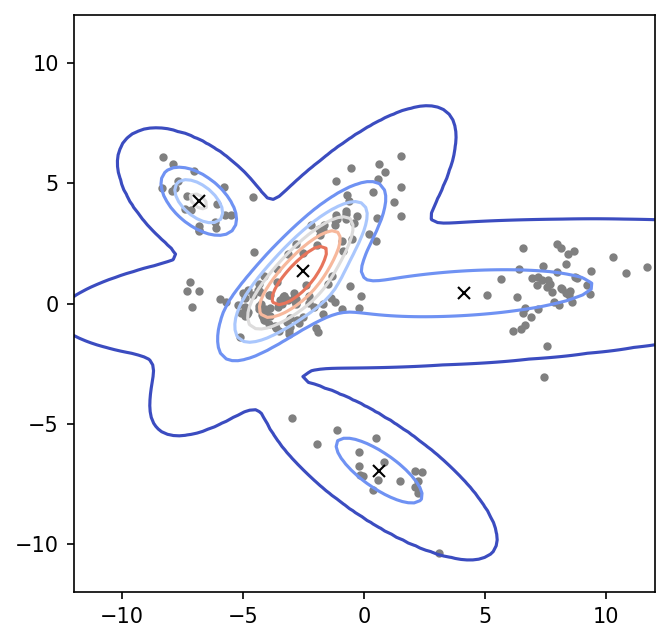

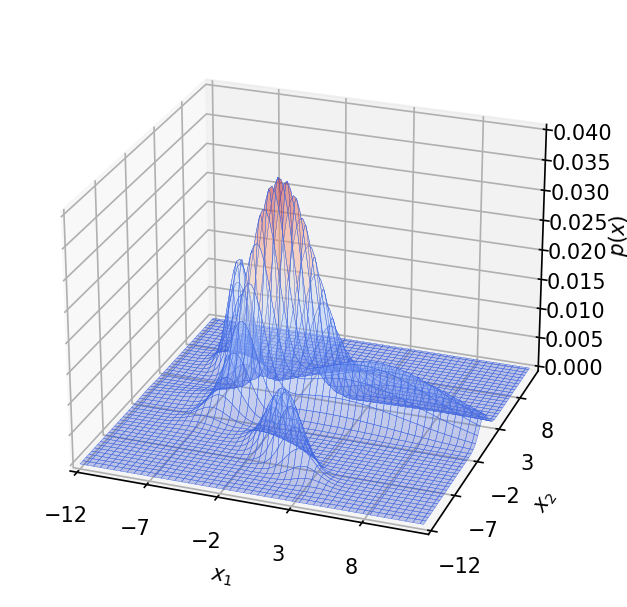

In [97]:
#Increase num of iterations:
pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs, nIter=500)

# Define GMM and plot
gmm = GMM(pred_means, pred_covs, pred_coefs)

def pdf_func(points):
    return np.array([gmm.pdf(p) for p in points])

plot_contours(pdf_func, X, means=pred_means)
plot_surface(pdf_func, X)

---

*YOUR ANSWER HERE*



---

## 10.3 - Using sklearn

Here we explore the SciKit Learn solution to do the same as above. In sklearn, the EM algorithm is integrated in the GMM class' `fit()` function.

To compare it to our own implementation, we will initialise it ourselves manually, to the same values as we did with ours (we will always be recalculating ours with the same initial conditions).

In [98]:
nComponents = 4
means, covs, coefs = initialise(nComponents)

# The sklearn implementation requires precisions instead of covariance matrices (which are just the inverse of the covariances)
precs = np.linalg.inv(covs)

In [99]:
from sklearn.mixture import GaussianMixture

gmm_sklearn = GaussianMixture(n_components=nComponents, weights_init = coefs, means_init = means, precisions_init = precs, max_iter = 100).fit(data)
print(gmm_sklearn.means_)
print(gmm_sklearn.covariances_)

[[ 6.32051435 -2.6746736 ]
 [ 5.07873893 -7.27607736]
 [ 5.13166834 -0.25366894]
 [ 4.38353732 -1.64202919]]
[[[ 2.41567466e+00  5.80647259e-01]
  [ 5.80647259e-01  9.44906870e-01]]

 [[ 2.59960644e+00 -2.39462600e-01]
  [-2.39462600e-01  4.67752906e-01]]

 [[ 1.00000831e-06 -4.10993154e-13]
  [-4.10993154e-13  1.00000002e-06]]

 [[ 8.40795805e-01  1.97105509e-01]
  [ 1.97105509e-01  1.14972669e-01]]]


Let's visualise the results of sklearn.

*NOTE: There is no equivalent to our `pdf()` function... Instead, the function that we can use here is called `GaussianMixture.score_samples()` and returns the log likelihood, while we want to plot the likelihood. So, to compare equal things we we need to exponantiate this.*

In [100]:
def f(x):
    return np.exp(gmm_sklearn.score_samples(x))

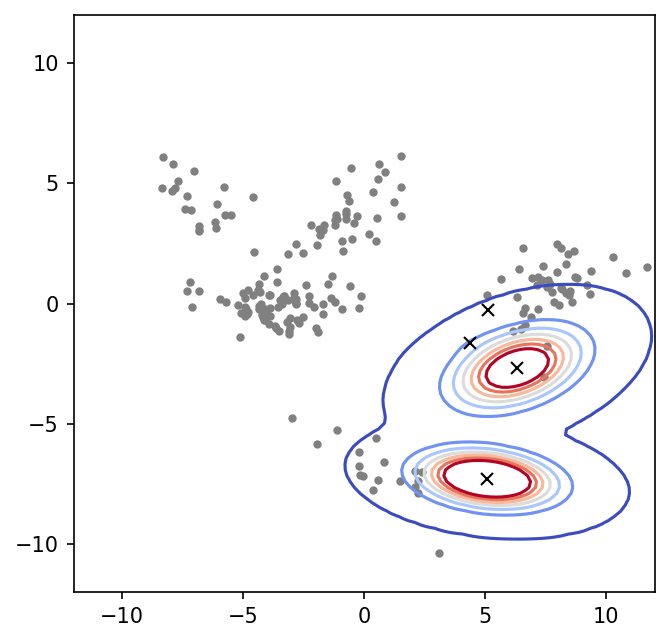

In [101]:
plot_contours(f, X, gmm_sklearn.means_)

<font color = "blue">Compare these results to our implementation, to make sure our implementation works well (make sure you are using the same initial values).</font>

c:\Users\sonia\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


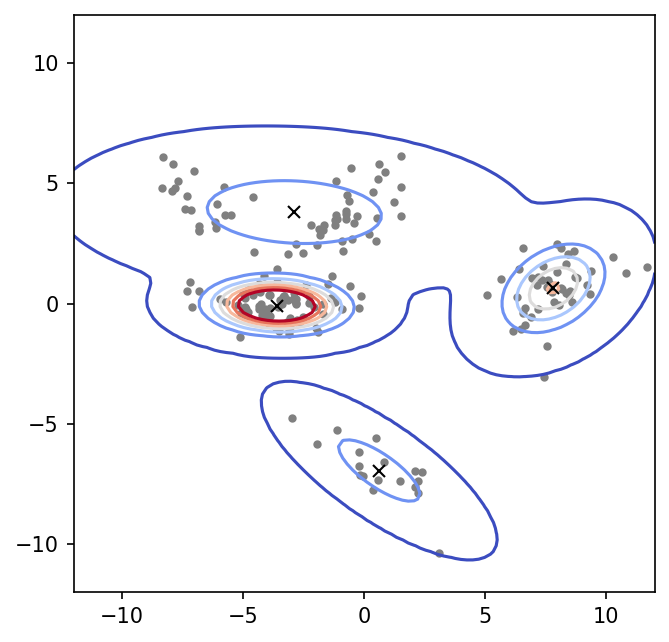

SciKit Learn Predicted Means:
 [[ 7.8126044   0.63749159]
 [ 0.61795574 -6.9357382 ]
 [-2.88452414  3.80601161]
 [-3.61622233 -0.07818528]]
SciKit Learn Predicted Covariances:
 [[[ 1.61246994  0.48334602]
  [ 0.48334602  1.20433939]]

 [[ 2.47693812 -1.45434475]
  [-1.45434475  1.43309896]]

 [[10.02663909 -0.43248203]
  [-0.43248203  1.31642049]]

 [[ 2.15974807 -0.05607789]
  [-0.05607789  0.35398484]]]
SciKit Learn Mixing Coefficients:
 [0.22460781 0.09000041 0.29190617 0.3934856 ]


In [102]:
# YOUR CODE HERE
gmm_sklearn = GaussianMixture(
    n_components=nComponents,
    weights_init=coefs,
    means_init=means,
    precisions_init=precs,
    max_iter=100
).fit(X)

# Extract the parameters from the sklearn model
sklearn_means = gmm_sklearn.means_
sklearn_covs = gmm_sklearn.covariances_
sklearn_weights = gmm_sklearn.weights_

# Define a function for sklearn's PDF calculation
def sklearn_pdf(x):
    return np.exp(gmm_sklearn.score_samples(x))

# Plot contours for sklearn's GMM
plot_contours(f, X, sklearn_means)

# Compare results
print("SciKit Learn Predicted Means:\n", sklearn_means)

print("SciKit Learn Predicted Covariances:\n", sklearn_covs)

print("SciKit Learn Mixing Coefficients:\n", sklearn_weights)


# 10.4 - Make Predictions

The original dataset also had class information. Therefore we can calculate the likelihood (class conditional probability of x) for each class, as well as the prior of each class, and then use it to predict posterior probabilities for new data.

<font color = "blue">Calculate the prior probabilities of the two classes</font>

In [103]:
# YOUR CODE HERE
total_samples = len(y)
nums_class_0 = np.sum(y == 0)
nums_class_1 = np.sum(y == 1)

# Calculate the prior probabilities
class0_prior  = nums_class_0 / total_samples
class1_prior  = nums_class_1 / total_samples

print("Class 0: Prior Probability:", class0_prior)
print("Class 1: Prior Probability:", class1_prior)


Class 0: Prior Probability: 0.315
Class 1: Prior Probability: 0.685


<font color = "blue">Calculate the class likelihoods (class conditioned probability density functions) for the two classes, using EM</font>

In [109]:
# YOUR CODE HERE
""""
class_likelihoods = [multivariate_normal(mean=means[k], cov=covs[k]).pdf(X) for k in range(len(pred_means))]

# Print the likelihoods
print("Likelihoods for class 0:", class_likelihoods[0])
print("Likelihoods for class 1:", class_likelihoods[1])
"""
class_likelihoods = []

for k in range(len(pred_means)):
    likelihood_k = multivariate_normal.pdf(X, mean=pred_means[k], cov=pred_covs[k])
    class_likelihoods.append(likelihood_k)

print("Likelihoods for class 0:", class_likelihoods[0])
print("Likelihoods for class 1:", class_likelihoods[1])


Likelihoods for class 0: [1.02879575e-39 5.51086012e-22 1.97497076e-17 2.45183905e-15
 1.09963454e-03 2.38351398e-22 4.20632290e-49 6.11669249e-25
 2.47063617e-22 1.32854337e-19 2.72616578e-18 1.34627794e-24
 4.74806623e-19 4.29892196e-14 2.67627448e-24 1.28049803e-26
 1.03414483e-01 4.25515381e-18 3.29127624e-02 7.65546043e-02
 3.66222606e-02 6.05835514e-02 4.42468267e-25 3.57842888e-15
 1.09900515e-01 7.23247054e-17 4.55027428e-19 1.01415549e-01
 2.32172270e-02 1.59896423e-16 9.16782350e-02 1.15337163e-01
 4.65739161e-20 9.84961871e-03 4.97436177e-15 9.49437910e-19
 5.84252651e-24 1.06242759e-01 2.65084771e-04 5.64269729e-19
 4.36991712e-13 8.06711873e-02 1.17940290e-35 1.18215093e-50
 3.67011093e-18 1.12932497e-14 3.30836912e-23 1.79470709e-34
 1.05743799e-18 2.38653604e-45 4.17547198e-02 4.00233907e-16
 1.53396863e-21 1.15397315e-24 7.28412819e-15 1.95414509e-26
 6.50926968e-02 5.19872102e-21 1.45716547e-14 1.65849099e-02
 1.20827143e-01 4.70246871e-18 1.05027718e-02 1.09599715e-13

<font color = "blue">Now apply Bayes, and calculate the posterior probabilities for each class for points [-3, 2], [7, 0], [1,-6], [5, -5]. To which class would you classify each point?</font>

In [ ]:
# YOUR CODE HERE
points = np.array([[-3, 2], [7, 0], [1, -6], [5, -5]])

# Calculate the posterior probabilities for each point in a more compact way
posteriors_prob = np.array([
    np.array([
        pred_coefs[i] * multivariate_normal.pdf(point, mean=pred_means[i], cov=pred_covs[i])
        for i in range(len(pred_means))
    ]) for point in points
])

posteriors_prob /= np.sum(posteriors_prob, axis=1)


In [121]:
# YOUR CODE HERE (Cont.)
classification = np.argmax(posteriors_prob, axis=1)

for i, point in enumerate(points):
    print(f"Point {point} is classified as class {classification[i]} with posterior probabilities {posteriors_prob[i]}")


Point [-3  2] is classified as class 2 with posterior probabilities [2.25772549e-22 3.42923797e-21 3.48150423e-03 1.42642864e-04]
Point [7 0] is classified as class 0 with posterior probabilities [2.07138660e-02 5.22570280e-49 1.06554879e-06 3.17952147e-13]
Point [ 1 -6] is classified as class 1 with posterior probabilities [7.21910990e-13 3.63376750e-03 6.43954814e-19 1.37270627e-24]
Point [ 5 -5] is classified as class 0 with posterior probabilities [4.57072426e-08 5.92572005e-12 2.74587833e-16 7.77502904e-23]


<font color = "blue">Make a function to classify a point using the Bayes rule.</font>

In [119]:
# YOUR CODE HERE
def classify_point(point, pred_means, pred_covs, pred_coefs):
    likelihoods = np.array([
        coefs[i] * multivariate_normal.pdf(point, mean=pred_means[i], cov=pred_covs[i])
        for i in range(len(pred_means))
    ])
    
    posterior_probs = likelihoods / likelihoods.sum()  # Normalize to get P(C_k | x)
    classification = np.argmax(posterior_probs)
    
    return classification, posterior_probs
